# Лабортаторная работа №4

### По курсу "нейроинформатика"

студент: Гаврилов М.С.  
группа: М8О-406Б-19  
вариант: 11

##### Цель работы:
Исследование свойств некоторых видов сетей с радиальными базисными элементами, алгоритмов обучения, а также применение сетей в задачах классификации и аппроксимации функции.

In [1]:
import numpy as np
import pylab

import torch
import torch.nn as nn
import copy
import random
import sklearn as skl
import sklearn.metrics

from tqdm import tqdm #визуал для циклов

## 1. Классификация точек

#### Области:
* Эллипс. a = 0.4, b = 0.15, alph = pi/3, x0 = -0.2, y0 = -0.18
* Эллипс. a = 0.4, b = 0.5, alph = -pi/3, x0 = -0.2, y0 = -0.18
* Эллипс. a = 1, b = 1, alph = 0, x0 = 0, y0 = 0

In [2]:
# Уравнение эллипса в параметрическом виде.
def ellipse(t,inp_arr):
    a, b, x0, y0 = copy.deepcopy(inp_arr)
    
    x = x0 + a * np.cos(t)
    y = y0 + b * np.sin(t)
    return x, y
# Уравнение параболы в параметрическом виде.
def parabola(t, p, x0, y0):
    x = x0 + t ** 2 / (2. * p)
    y = y0 + t
    return x, y
# Функция вращения фигуры на заданный угол.
def rotate(pt, alpha):
    x,y = pt
    xr = x * np.cos(alpha) - y * np.sin(alpha)
    yr = x * np.sin(alpha) + y * np.cos(alpha)
    return xr, yr

In [3]:
ellipse1 = [0.4,0.15,-0.2,-0.18]
ellipse2 = [0.4,0.5,-0.2,-0.18]
ellipse3 = [1,1,0,0]

In [4]:
ell_arr_1 = []
for t in range(0,1000,1):
    ell_arr_1.append(rotate(ellipse(t/100,ellipse1),np.pi/3))
ell_arr_1 = np.array(ell_arr_1)

ell_arr_2 = []
for t in range(0,1000,1):
    ell_arr_2.append(rotate(ellipse(t/100,ellipse2),-np.pi/3))
ell_arr_2 = np.array(ell_arr_2)

ell_arr_3 = []
for t in range(0,1000,1):
    ell_arr_3.append(ellipse(t/100,ellipse3))
ell_arr_3 = np.array(ell_arr_3)

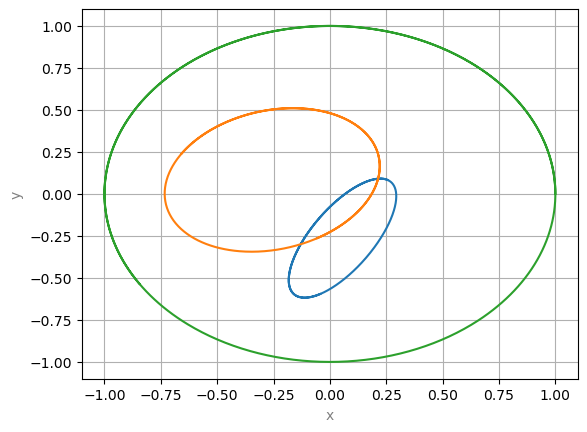

In [5]:
pylab.xlabel("x",color = "grey")
pylab.ylabel("y",color = "grey")
pylab.grid()
pylab.plot(ell_arr_1[:,0],ell_arr_1[:,1])
pylab.plot(ell_arr_2[:,0],ell_arr_2[:,1])
pylab.plot(ell_arr_3[:,0],ell_arr_3[:,1])
pylab.show()

#### Функции для построения датасета:

In [6]:
def in_ellipse(ell_arr,pt,rot = 0):
    a,b,x0,y0 = ell_arr
    pt = rotate(pt,-rot)
    
    return (((pt[0]-x0)*(pt[0]-x0))/(a*a) + ((pt[1]-y0)*(pt[1]-y0))/(b*b) < 1)
    

In [7]:
def make_dataset_on(sel_cnt = 1000,class_cnt = 500):
    data_X = []
    data_L = []
    for i in range (sel_cnt):
        pt = random.random()*10
        choose = random.random()*3
        if(choose > 2):
            data_X.append(rotate(ellipse(pt,ellipse1),np.pi/3))
            data_L.append(0)
            continue
            
        if(choose > 1):
            data_X.append(rotate(ellipse(pt,ellipse2),-np.pi/3))
            data_L.append(1)
            continue
            
        if(choose >= 0):
            data_X.append(ellipse(pt,ellipse3))
            data_L.append(2)
            continue

    return np.array(data_X),np.array(data_L)

def make_dataset_in(sel_cnt = 30000,class_cnt = 500):
    class_cnt = [0,0,0]
    data_X = []
    data_L = []
    for i in range (30000):
        pt = [(random.random()*2)-1,(random.random()*2)-1]


        if(in_ellipse(ellipse1,pt,np.pi/3) and class_cnt[0] < 1000):
            data_X.append(pt)
            data_L.append(0)
            class_cnt[0] += 1
            continue

        if(in_ellipse(ellipse2,pt,-np.pi/3) and class_cnt[1] < 1000):
            data_X.append(pt)
            data_L.append(1)
            class_cnt[1] += 1
            continue

        if(in_ellipse(ellipse3,pt) and class_cnt[2] < 1000):
            data_X.append(pt)
            data_L.append(2)
            class_cnt[2] += 1
            continue

    data_X = np.array(data_X)
    data_L = np.array(data_L)

    return np.array(data_X),np.array(data_L)

In [8]:
def calculate_wts(data_L):
    class_wts = []
    for i in range(np.max(data_L) + 1):
        class_wts.append(1 - (data_L == i).mean())
    class_wts = torch.tensor(class_wts,dtype = torch.float32)
    return class_wts

## Обучающие функции

In [14]:
def accuracy_mult(testRS,testLB):
    return (np.argmax(testRS,axis = 1) == testLB).mean()

def train(net,trainXX,trainLB,n_epochs,batch_size,lr,
         optimiser = torch.optim.SGD,
         criterion = torch.nn.CrossEntropyLoss(weight = class_wts),
         accuracy = accuracy_mult
         ):
    #функция, производящая обучение сети
    arr = []
    
    optim = optimiser(model.parameters(),lr=lr)
    
    num_batches = len(trainXX)/batch_size
    
    for i in tqdm(range(n_epochs)):
                
        for j in range(int(num_batches)):
            batchXX = trainXX[j*batch_size : (j+1)*batch_size]
            batchLB = trainLB[j*batch_size : (j+1)*batch_size]
            
            optim.zero_grad()
            loss = criterion(model(batchXX),batchLB)
            loss.backward()
            optim.step()
            
        #трэйсинг обучения
        arr.append([i,
                    loss.detach().numpy(), #значение ф-и потерь
                    accuracy(model(trainXX).detach().numpy(),trainLB.detach().numpy())]) #среднее количество совпадений в предсказаниях (точность)
                    
    return np.array(arr)

def plot_learning(arr):
    pylab.grid()
    pylab.xlabel("epochs",color = "grey")
    pylab.ylabel("loss",color = "grey")
    pylab.plot(arr[:,0],arr[:,1])
    pylab.show()
    
    pylab.grid()
    pylab.axis([0,len(arr),0,1])
    pylab.xlabel("epochs",color = "grey")
    pylab.ylabel("accuracy",color = "grey")
    pylab.plot(arr[:,0],arr[:,2])
    pylab.show()

## Классификация датасета с точками на эллипсах

In [10]:
data_X,data_L = make_dataset_on(sel_cnt = 1000,class_cnt = 500)

train_X = torch.tensor(data_X,dtype = torch.float32)
train_L = torch.tensor(data_L)

#### Демонстрация точек датасета:

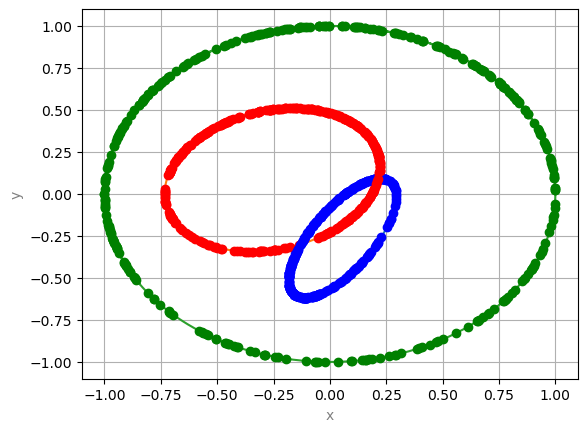

In [11]:
pylab.xlabel("x",color = "grey")
pylab.ylabel("y",color = "grey")
pylab.grid()
pylab.plot(ell_arr_1[:,0],ell_arr_1[:,1])
pylab.plot(ell_arr_2[:,0],ell_arr_2[:,1])
pylab.plot(ell_arr_3[:,0],ell_arr_3[:,1])

for i in range(len(data_X)):
    if(data_L[i] == 0):
        pylab.plot(data_X[i,0],data_X[i,1],'bo')
    if(data_L[i] == 1):
        pylab.plot(data_X[i,0],data_X[i,1],'ro')
    if(data_L[i] == 2):
        pylab.plot(data_X[i,0],data_X[i,1],'go')

pylab.show()

#### Обучение сети:

In [12]:
class_wts = calculate_wts(data_L)

In [13]:
class myRBF(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.bias = bias
        self.weight = torch.nn.Parameter(torch.randn(out_features, in_features))
        self.bias = torch.nn.Parameter(torch.randn(out_features))
       
        
    def forward(self, input):
        x, y = input.shape
        if y != self.in_features:
            sys.exit(f'Wrong Input Features. Please use tensor with {self.in_features} Input Features')
        output = input @ self.weight.t() + self.bias
        return output

## RBF-модуль:

In [80]:
class myRBF(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        
        self.wts_mean = torch.nn.Parameter(torch.randn(out_features,in_features))
        self.wts_area = torch.nn.Parameter(torch.randn(out_features))
       
        
    def forward(self, input):
        x, y = input.shape
        if y != self.in_features:
            sys.exit(f'Wrong Input Features. Please use tensor with {self.in_features} Input Features')
        
        output = torch.exp((input @ self.wts_mean.t()) * self.wts_area)
        return output

In [81]:
rb = myRBF(4,2)

In [82]:
torch.mul(torch.tensor([1,2]),torch.tensor([3,4]))

tensor([3, 8])

In [102]:
model = torch.nn.Sequential(
    myRBF(2,30),
    nn.Tanh(),
    myRBF(30,40),
    nn.Tanh(),
    myRBF(40,3),
    nn.Softmax(dim = 1)
)

arr = train(model,train_X,train_L,1000,50,0.05,criterion = torch.nn.CrossEntropyLoss(weight = class_wts))

100%|██████████████████████████████████████| 1000/1000 [00:07<00:00, 136.31it/s]


#### Подсчет метрик

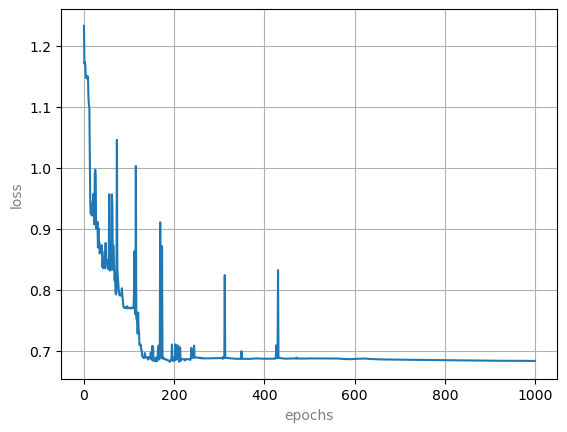

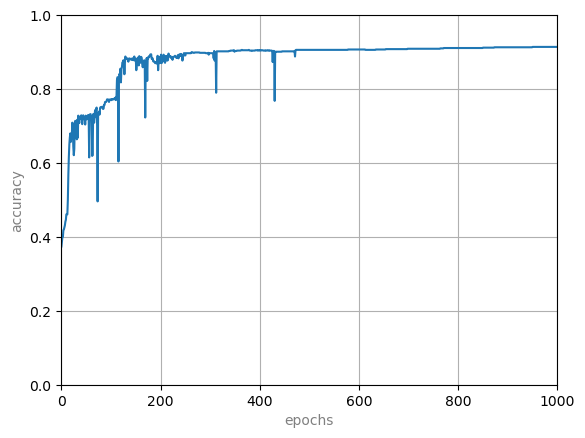


accuracy:

0.914
              precision    recall  f1-score   support

           0       0.80      1.00      0.89       337
           1       1.00      0.80      0.89       348
           2       1.00      0.94      0.97       315

    accuracy                           0.91      1000
   macro avg       0.93      0.92      0.92      1000
weighted avg       0.93      0.91      0.91      1000



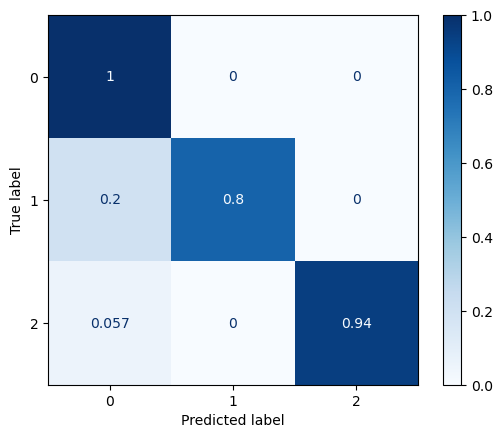

In [103]:
plot_learning(arr)
print("\naccuracy:\n")
print((np.argmax(model(train_X).detach().numpy(),axis = 1) == np.array(train_L)).mean())

print(skl.metrics.classification_report(data_L,np.argmax(model(train_X).detach().numpy(),axis = 1)))

m = skl.metrics.ConfusionMatrixDisplay.from_predictions(data_L,
                                                  np.argmax(model(train_X).detach().numpy(),axis = 1),
                                                  normalize = 'true',
                                                  cmap = pylab.cm.Blues)

#### Графическая демонстрация классификации:

blue - correct 
red  - wrong



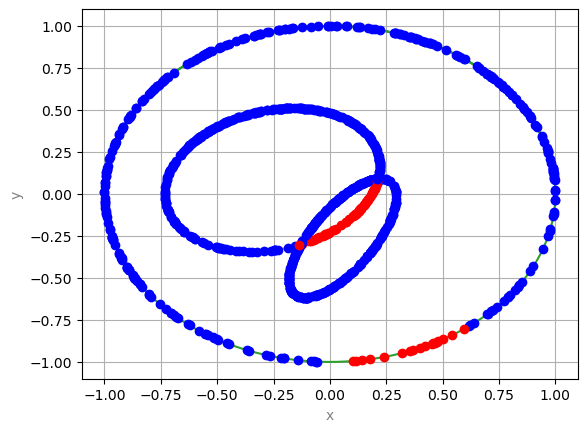

In [104]:
print("blue - correct \nred  - wrong\n")

pylab.xlabel("x",color = "grey")
pylab.ylabel("y",color = "grey")
pylab.grid()
pylab.plot(ell_arr_1[:,0],ell_arr_1[:,1])
pylab.plot(ell_arr_2[:,0],ell_arr_2[:,1])
pylab.plot(ell_arr_3[:,0],ell_arr_3[:,1])

for i in range(len(data_X)):
    if(data_L[i] == torch.argmax(model(train_X[i].reshape(1,2)))):
        pylab.plot(data_X[i,0],data_X[i,1],'bo')
    else:
        pylab.plot(data_X[i,0],data_X[i,1],'ro')

pylab.show()

Correct Labels


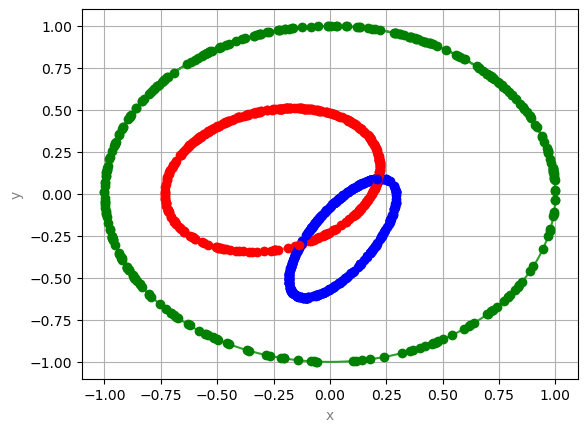

Predicted Labels


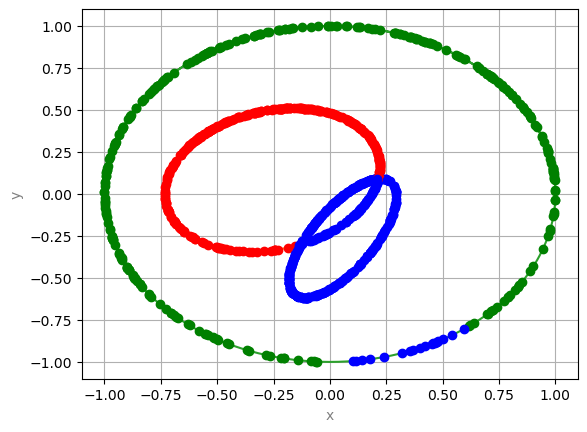

In [105]:
print("Correct Labels")
pylab.xlabel("x",color = "grey")
pylab.ylabel("y",color = "grey")
pylab.grid()
pylab.plot(ell_arr_1[:,0],ell_arr_1[:,1])
pylab.plot(ell_arr_2[:,0],ell_arr_2[:,1])
pylab.plot(ell_arr_3[:,0],ell_arr_3[:,1])

for i in range(len(data_X)):
    if(data_L[i] == 0):
        pylab.plot(data_X[i,0],data_X[i,1],'bo')
    if(data_L[i] == 1):
        pylab.plot(data_X[i,0],data_X[i,1],'ro')
    if(data_L[i] == 2):
        pylab.plot(data_X[i,0],data_X[i,1],'go')

pylab.show()
print("Predicted Labels")
pylab.plot(ell_arr_1[:,0],ell_arr_1[:,1])
pylab.plot(ell_arr_2[:,0],ell_arr_2[:,1])
pylab.plot(ell_arr_3[:,0],ell_arr_3[:,1])

pylab.xlabel("x",color = "grey")
pylab.ylabel("y",color = "grey")
pylab.grid()
for i in range(len(data_X)):
    if(torch.argmax(model(train_X[i].reshape(1,2))) == 0):
        pylab.plot(data_X[i,0],data_X[i,1],'bo')
    if(torch.argmax(model(train_X[i].reshape(1,2))) == 1):
        pylab.plot(data_X[i,0],data_X[i,1],'ro')
    if(torch.argmax(model(train_X[i].reshape(1,2))) == 2):
        pylab.plot(data_X[i,0],data_X[i,1],'go')

pylab.show()

### Классификация пространственного датасета той же сетью:

In [106]:
data_X,data_L = make_dataset_in(sel_cnt = 1000,class_cnt = 500)

train_X = torch.tensor(data_X,dtype = torch.float32)
train_L = torch.tensor(data_L)

blue - correct 
red  - wrong



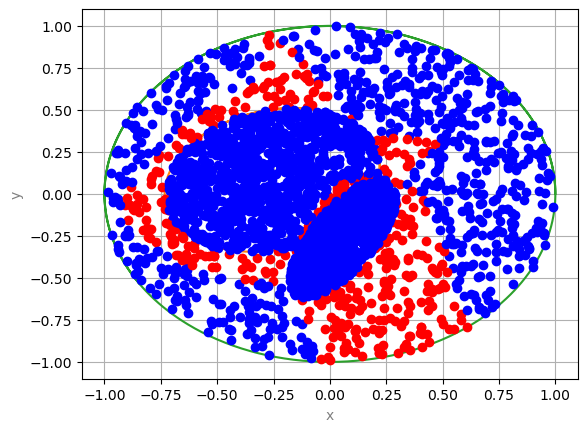

In [107]:
print("blue - correct \nred  - wrong\n")

pylab.xlabel("x",color = "grey")
pylab.ylabel("y",color = "grey")
pylab.grid()
pylab.plot(ell_arr_1[:,0],ell_arr_1[:,1])
pylab.plot(ell_arr_2[:,0],ell_arr_2[:,1])
pylab.plot(ell_arr_3[:,0],ell_arr_3[:,1])

for i in range(len(data_X)):
    if(data_L[i] == torch.argmax(model(train_X[i].reshape(1,2)))):
        pylab.plot(data_X[i,0],data_X[i,1],'bo')
    else:
        pylab.plot(data_X[i,0],data_X[i,1],'ro')

pylab.show()

Correct Labels


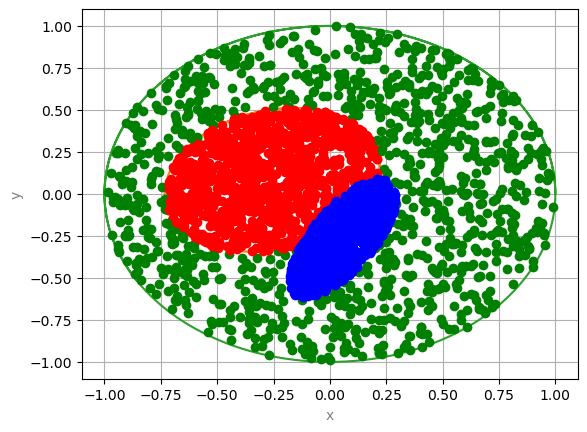

Predicted Labels


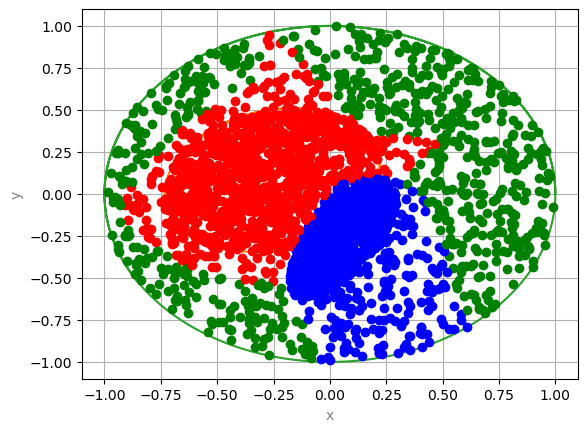

In [108]:
print("Correct Labels")
pylab.xlabel("x",color = "grey")
pylab.ylabel("y",color = "grey")
pylab.grid()
pylab.plot(ell_arr_1[:,0],ell_arr_1[:,1])
pylab.plot(ell_arr_2[:,0],ell_arr_2[:,1])
pylab.plot(ell_arr_3[:,0],ell_arr_3[:,1])

for i in range(len(data_X)):
    if(data_L[i] == 0):
        pylab.plot(data_X[i,0],data_X[i,1],'bo')
    if(data_L[i] == 1):
        pylab.plot(data_X[i,0],data_X[i,1],'ro')
    if(data_L[i] == 2):
        pylab.plot(data_X[i,0],data_X[i,1],'go')

pylab.show()
print("Predicted Labels")
pylab.plot(ell_arr_1[:,0],ell_arr_1[:,1])
pylab.plot(ell_arr_2[:,0],ell_arr_2[:,1])
pylab.plot(ell_arr_3[:,0],ell_arr_3[:,1])

pylab.xlabel("x",color = "grey")
pylab.ylabel("y",color = "grey")
pylab.grid()
for i in range(len(data_X)):
    if(torch.argmax(model(train_X[i].reshape(1,2))) == 0):
        pylab.plot(data_X[i,0],data_X[i,1],'bo')
    if(torch.argmax(model(train_X[i].reshape(1,2))) == 1):
        pylab.plot(data_X[i,0],data_X[i,1],'ro')
    if(torch.argmax(model(train_X[i].reshape(1,2))) == 2):
        pylab.plot(data_X[i,0],data_X[i,1],'go')

pylab.show()

# 2. Аппроксимация функции

t in [0,4], h = 0.02

In [15]:
def func(t):
    return np.cos(t**2)

In [16]:
line = np.array([[i/1000,func(i/1000)] for i in range (0,4000)])

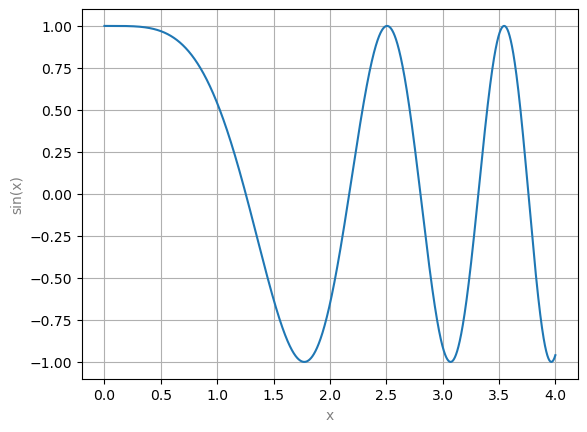

In [17]:
pylab.xlabel("x",color = "grey")
pylab.ylabel("sin(x)",color = "grey")
pylab.grid()
pylab.plot(line[:,0],line[:,1])
pylab.show()

In [18]:
def make_dataset(line,ln = 200):
    train_X = []
    train_Y = []
    for j in range(ln):
        i = int(random.random()*len(line))
        train_X.append([i/1000])
        train_Y.append([line[i][1]])

    train_X = torch.tensor(train_X,dtype = torch.float32)
    train_Y = torch.tensor(train_Y,dtype = torch.float)
    
    return train_X,train_Y

In [19]:
train_X,train_Y = make_dataset(line)
test_X,test_Y = make_dataset(line,ln = 1000)

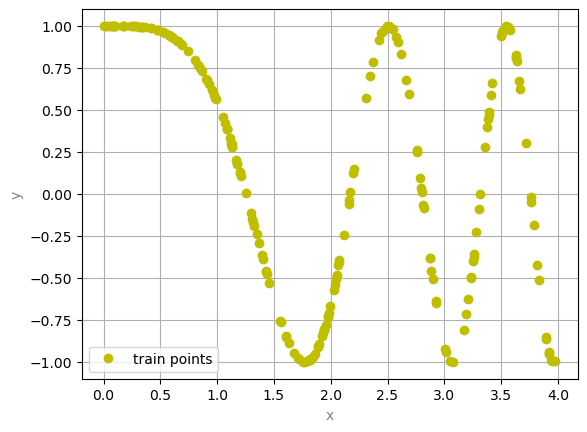

In [32]:
pylab.xlabel("x",color = "grey")
pylab.ylabel("y",color = "grey")
pylab.grid()
pylab.plot(train_X,train_Y,'yo',label = "train points")
pylab.legend()
pylab.show()

In [22]:
def accuracy_line(testRS,testLB):
    return (np.sum(abs(testRS - testLB)))

def train(net,trainXX,trainLB,n_epochs,batch_size,lr,
         optimiser = torch.optim.SGD,
         criterion = torch.nn.MSELoss(),
         accuracy = accuracy_line
         ):
    #функция, производящая обучение сети
    arr = []
    
    optim = optimiser(model.parameters(),lr=lr)
    
    num_batches = len(trainXX)/batch_size
    
    for i in tqdm(range(n_epochs)):
                
        for j in range(int(num_batches)):
            batchXX = trainXX[j*batch_size : (j+1)*batch_size]
            batchLB = trainLB[j*batch_size : (j+1)*batch_size]
            
            optim.zero_grad()
            loss = criterion(model(batchXX),batchLB)
            loss.backward()
            optim.step()
            
        #трэйсинг обучения
        arr.append([i,
                    loss.detach().numpy(), #значение ф-и потерь
                    accuracy(model(trainXX).detach().numpy(),trainLB.detach().numpy())]) #среднее количество совпадений в предсказаниях (точность)
                    
    return np.array(arr)

In [23]:
def plot_learning(arr):
    pylab.xlabel("epochs",color = "grey")
    pylab.ylabel("loss",color = "grey")
    pylab.plot(arr[:,0],arr[:,1])
    pylab.show()
    
def plot_both(pts_exmpl,pts_res,aditional_plot = None):
    arr_res = np.array([[(i)/1000 ,pts_res[i]] for i in range(len(pts_res))])
    arr_exm = np.array([[(i)/1000 ,pts_exmpl[i]] for i in range(len(pts_exmpl))])
    
    if(not np.array(aditional_plot == None).all()):
        pylab.plot(aditional_plot[:,0],aditional_plot[:,1],color = "red")
    
    print("blue   - target    line")
    print("orange - predictrd line")
    pylab.xlabel("x",color = "grey")
    pylab.ylabel("f(x)",color = "grey")
    pylab.grid()
    pylab.plot(arr_exm[:,0],arr_exm[:,1],'bo',color = "blue",linewidth = 3)
    pylab.plot(arr_res[:,0],arr_res[:,1],'ro',color = "orange",linewidth = 1.5)
    pylab.show()

In [24]:
train_X,train_Y = make_dataset(line)

model = torch.nn.Sequential(
    myRBF(1,30),
    nn.Tanh(),
    myRBF(30,40),
    nn.Tanh(),
    myRBF(40,20),
    nn.Tanh(),
    nn.Linear(20,1)
)

arr = train(model,train_X,train_Y,3000,20,0.07)

100%|██████████████████████████████████████| 3000/3000 [00:11<00:00, 254.28it/s]


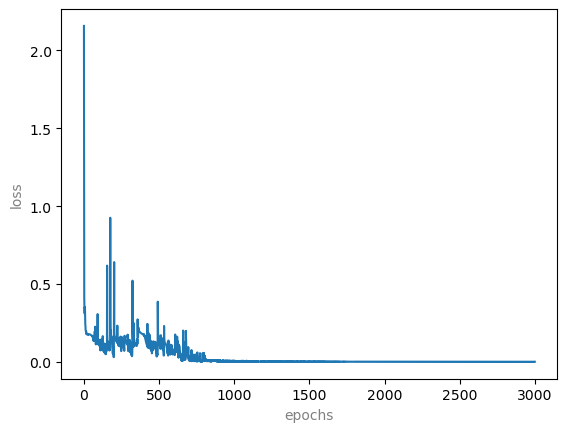

In [25]:
plot_learning(arr)

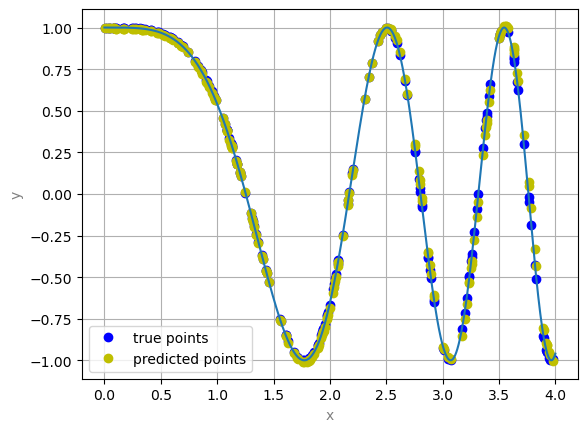

In [30]:
pylab.xlabel("x",color = "grey")
pylab.ylabel("y",color = "grey")
pylab.grid()
pylab.plot(train_X,train_Y,'bo',label = "true points")
pylab.plot(train_X,model(train_X).detach().numpy(),'yo',label = "predicted points")
pylab.plot(line[:,0],line[:,1])
pylab.legend()
pylab.show()

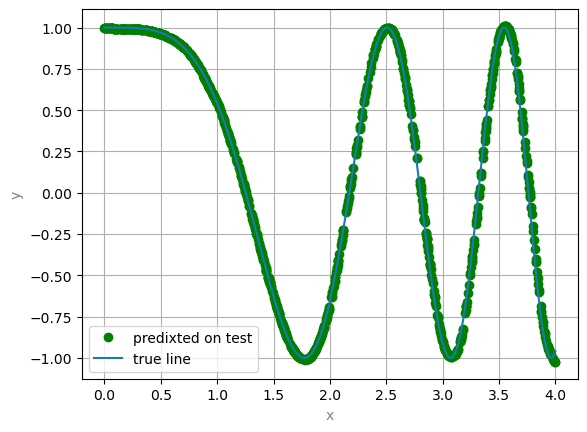

In [31]:
pylab.xlabel("x",color = "grey")
pylab.ylabel("y",color = "grey")
pylab.grid()
pylab.plot(test_X,model(test_X).detach().numpy(),'go',label = "predixted on test")
pylab.plot(line[:,0],line[:,1],label = "true line")
pylab.legend()
pylab.show()

## Вывод

В ходе выполнения этой лабораторной работы я получил опыт работы с RBF-сетями, а также научился создавать собственные слои в pytorch. Я решил задачу классификации точек в двухмерном пространстве и задачу аппроксимации функцию с помощью RBF-сети.